<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook optimization |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and files</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries</h3>
</div>

In [1]:
import re
import numpy as np
import pandas as pd
from functools import partial

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from lightgbm import LGBMClassifier

import sklearn
from sklearn.metrics import (roc_auc_score, roc_curve, 
                             precision_recall_curve, confusion_matrix, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay)
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparametrization
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

import joblib

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Files</h3>
</div>

In [2]:
df = pd.read_csv(r"datasets\df_processed.csv")
df = df.drop(columns=["index"])

In [3]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 356251 rows and 797 columns
- Total of NaN values:			 72099981
- Percentage of NaN:			 25.39 %
- Total of infinite values:		 21
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 2.1 GB


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li><b>Missing values</b> - There are 25.39% of missing-values to treat</li>
        <li><b>Infinite values</b> - There are 25 infinite values</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2.1 Optimizing memory usage</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [4]:
df["TARGET"].fillna(value=-99, inplace=True)
df["TARGET"] = df["TARGET"].astype("int8")
df["TARGET"] = df["TARGET"].replace(-99, np.nan)

In [5]:
for col in df.columns:
    if df[col].dtype == "int64" and df[col].nunique() == 2:
        df[col] = df[col].astype("int8")

In [6]:
for col in df.columns:
    if df[col].dtype == "float64" and df[col].min() >= -2147483648 and df[col].max() <= 2147483648:
        df[col] = df[col].astype("float32")

In [7]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 356251 rows and 797 columns
- Total of NaN values:			 72099981
- Percentage of NaN:			 25.39 %
- Total of infinite values:		 21
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 941.8 MB


In [8]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.select_dtypes(include=["object"]).columns.tolist()

[]

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li><b>Columns type</b> - All columns are numerics</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2.2. Missing-values</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Before treating the class imbalance in the target, it is necessary to treat the missing-values in all the dataset, to do that, we are going to fill values with SimpleImputer
   </p>
    <p>Let's start by identifying the features with infinite-values and replace them by missing-values
   </p>
</div>
</div>

In [10]:
inf_cols = df.columns.to_series()[np.isinf(df).any()]

In [11]:
for col in inf_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

In [12]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 356251 rows and 797 columns
- Total of NaN values:			 72100002
- Percentage of NaN:			 25.39 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 941.8 MB


<div class="alert alert-block alert-info">
    <p>Let's continue by identifying the features with missing-values and excluding the TARGET
   </p>
</div>
</div>

In [13]:
nan_cols = [i for i in df.columns if i!="TARGET" and df[i].isnull().any()]

In [14]:
for col in nan_cols:
    mean_value = df[col].mean()
    df[col].fillna(value=mean_value, inplace=True)

In [15]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 356251 rows and 797 columns
- Total of NaN values:			 48744
- Percentage of NaN:			 0.02 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 941.8 MB


<div class="alert alert-block alert-success">
    <p>At this point, TARGET is the only column with missing-values</p>
</div>

In [16]:
# saving the optimized dataset 
#df.to_csv("datasets\df_optimized.csv", index=False)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Class Imbalance</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Verifying</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to analyze in details, whether ours target has an imbalanced class
   </p>
</div>

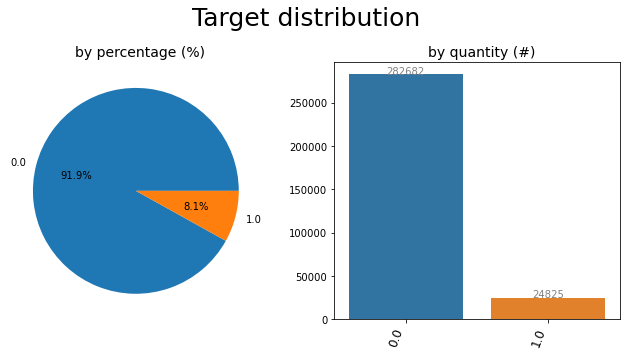

In [17]:
barplot_and_pie(df["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p>Here we can see how much the dataset is imbalanced</p>
    <p>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b></p>   
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Smote</h3>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the Imbalanced class, we are going to use a type of data augmentation for the minority class (Oversampling) where new examples can be synthesized from the existing examples and it is referred as the Synthetic Minority Oversampling Technique - SMOTE.</p>
</div>

In [18]:
train_df = df[df["TARGET"].notnull()]
test_df = df[df["TARGET"].isnull()]

In [19]:
X = train_df.drop(columns=["TARGET"])

In [20]:
y = train_df.loc[:,"TARGET"]

<div class="alert alert-block alert-info">
    <p>Initializing SMOTE</p>
</div>

In [21]:
smote = SMOTE(sampling_strategy="auto", k_neighbors=5, n_jobs=-1,
              random_state=42)

<div class="alert alert-block alert-info">
    <p>Executing SMOTE</p>
</div>

In [22]:
X_resampled, y_resampled = smote.fit_resample(X, y)

<div class="alert alert-block alert-info">
    <p>Finally, we can see the results</p>
</div>

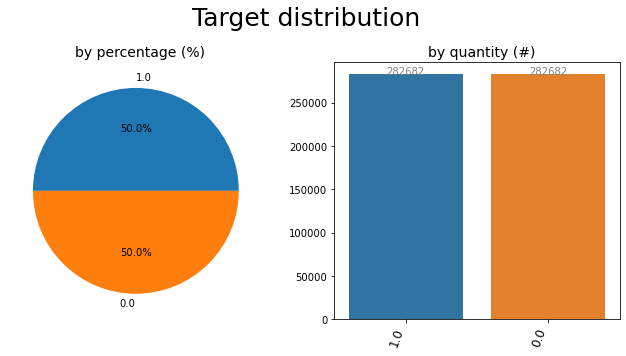

In [23]:
barplot_and_pie(y_resampled, "Target distribution", " ")

<div class="alert alert-block alert-success">
    <p>Now, we have the Target balanced</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.4. Rebuild the dataset</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Creating series with attributes</p>
</div>

In [24]:
y_resampled  = pd.Series(y_resampled, name="TARGET")

<div class="alert alert-block alert-info">
    <p>Merging result dataset with result series</p>
</div>

In [25]:
df_resampled = X_resampled.merge(y_resampled, left_index=True, right_index=True)

<div class="alert alert-block alert-info">
    <p>Concatenating the dataset</p>
</div>

In [26]:
df_resampled = pd.concat([df_resampled, test_df])

In [27]:
# saving the resampled dataset 
#df_resampled.to_csv("datasets\df_resampled.csv", index=False)

<div class="alert alert-block alert-info">
    <p>Freeing up memory </p>
</div>

In [28]:
del df, train_df, test_df, X, y, X_resampled, y_resampled
gc.collect()

9870

<div class="alert alert-block alert-info">
    <p>Let's see the final dataset</p>
</div>

In [29]:
df_analysis(df_resampled, "df_resampled", analysis_type="header")


Analysis Header of df_resampled dataset
--------------------------------------------------------------------------------
- Dataset shape:			 614108 rows and 797 columns
- Total of NaN values:			 48744
- Percentage of NaN:			 0.01 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 False
- Memory usage:				 1.6 GB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point we have the following dataset.</p>
    <ul style="list-style-type: square;">
        <li><b>df_resampled</b>: that is balanced after treating it through SMOTE and shape 614108 x 797</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimization</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use a <b>Custom Score</b> and <b>Hyperopt</b> to get the best result to set the model </p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Custom Score</h3>
</div>

<div class="alert alert-block alert-info">
    <p>In the <b>Custom Score</b>, we are going to penalize the <b>False Negative</b> that are loands <b>will be in default</b>, and they were <b>predicted incorrectly</b></p>
</div>

In [30]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Model optimiztion</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the parameters</p>
</div>

In [31]:
N_ESTIMATORS = [8000, 10000, 12000]
NUM_LEAVES = [32, 34, 36]
MAX_DEPTH = [7, 8, 9]

In [32]:
space_params = {
    "n_estimators" : hp.choice("n_estimators", N_ESTIMATORS),
    "learning_rate" :  hp.uniform("learning_rate", 0.002, 0.003),
    "num_leaves" :  hp.choice("num_leaves", NUM_LEAVES),
    "max_depth" : hp.choice("max_depth", MAX_DEPTH),
    "reg_alpha" : hp.uniform("reg_alpha", 0.041545473, 0.051),
    "reg_lambda" : hp.uniform("reg_lambda", 0.0735294, 0.0835294),
    "min_split_gain" : hp.uniform("min_split_gain", 0.0222415, 0.0322415),
    "min_child_weight" : hp.uniform("min_child_weight", 39.3259775, 49)
}

<div class="alert alert-block alert-info">
    <p>Now, we can define our objective function</p>
    <p>To do that, we are going to consider the following</p>
    <ul style="list-style-type: square;">
        <li><b>StandardScaler</b> to manage all data in the same scale</li>
        <li><b>colsample_bytree and subsample</b> with 80% of data, to improve the execution time</li>
        <li><b>n_splits</b> with 2 to improve the execution time</li>
        <li><b>is_unbalance</b> with False because it is a balanced dataset</li>
    </ul> 
</div>

In [33]:
def hyperparameter_tuning(space_params, df, imbalanced, n_splits):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        space_params (dict): Parameters to optimize the model
        df (pandas.DataFrame): Dataset to treat
        imbalanced (boolean): Define whether dataset is unbalanced
        n_splits (int): To split data in train test sets

    Returns:
    -----------------
        Loss and STATUS.
    """
    
    # Formatting columns name
    df = df.rename(columns=lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    df_lgbm = df.copy()
    
    scaler = StandardScaler()
    
    # Divide in training/validation and test data
    train_df = df_lgbm[df_lgbm["TARGET"].notnull()]
    test_df = df_lgbm[df_lgbm["TARGET"].isnull()]
    del df_lgbm
    gc.collect()
    
    # Cross validation model
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feats = [f for f in train_df.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["TARGET"])):
        
        print("\n")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]
    
        train_x_scaled = scaler.fit_transform(train_x)
        valid_x_scaled = scaler.fit_transform(valid_x)
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            **space_params,
            colsample_bytree=0.8, 
            subsample=0.8,
            is_unbalance=imbalanced,
            n_jobs=-1 
        )
        
        evaluation = [(train_x_scaled, train_y), (valid_x_scaled, valid_y)]
        
        clf.fit(train_x_scaled, train_y, eval_set=evaluation, eval_metric="auc",
                callbacks=[lgb.early_stopping(stopping_rounds=200),
                          lgb.log_evaluation(period=-1)])
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x_scaled, num_iteration=clf.best_iteration_)[:, 1]
        
        del clf, train_x, train_x_scaled, train_y, valid_x, valid_x_scaled, valid_y
        gc.collect()
    
    auc = roc_auc_score(train_df["TARGET"], oof_preds)
    print(">> ROC-AUC Score %.6f" % auc )
    
    cs = custom_score(train_df["TARGET"], oof_preds)
    print(">> Custom Score %.6f\n" % cs )
          
    return { "loss": -auc, "status": STATUS_OK } 

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Balanced dataset modelisation</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Finally, we are going to optimize the model with the <b>balanced</b> dataset</p>
</div>

In [34]:
fmin_objective = partial(hyperparameter_tuning, 
                         df=df_resampled, imbalanced=False,
                         n_splits=2)

In [35]:
# Initialize trials object
trials = Trials()

best = fmin(
    fn=fmin_objective,
    space=space_params, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

Training until validation scores don't improve for 200 rounds                                                          
Early stopping, best iteration is:                                                                                     
[410]	training's auc: 0.968512	training's binary_logloss: 0.400138	valid_1's auc: 0.901318	valid_1's binary_logloss: 0.581033
Training until validation scores don't improve for 200 rounds                                                          
Early stopping, best iteration is:                                                                                     
[496]	training's auc: 0.970043	training's binary_logloss: 0.368037	valid_1's auc: 0.903632	valid_1's binary_logloss: 0.56389
>> ROC-AUC Score 0.901770                                                                                              
>> Custom Score 0.911631                                                                                               

Training until validation sc

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.1. The best parameters</h4>
</div>

<div class="alert alert-block alert-success">
    <p>Let's print the best parameters</p>
</div>

In [36]:
print("Best: {}".format(best))

Best: {'learning_rate': 0.002996768103678267, 'max_depth': 1, 'min_child_weight': 43.56681976377634, 'min_split_gain': 0.025360811467421862, 'n_estimators': 0, 'num_leaves': 1, 'reg_alpha': 0.047205508056568875, 'reg_lambda': 0.07740351793970067}


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.4. Final model</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to execute our model based on the best parameters</p>
</div>

In [37]:
# Formatting columns name
df_resampled = df_resampled.rename(columns=lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
df_lgbm = df_resampled.copy()
    
scaler = StandardScaler()
    
# Divide in training/validation and test data
train_df = df_lgbm[df_lgbm["TARGET"].notnull()]
test_df = df_lgbm[df_lgbm["TARGET"].isnull()]
del df_lgbm
gc.collect()

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
feature_importance_df = pd.DataFrame()

<div class="alert alert-block alert-info">
    <p>Splitting and scale the data</p>
</div>

In [38]:
# Split dataset to train
X = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y_target = train_df.loc[:, "TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.33, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<div class="alert alert-block alert-info">
    <p>Initializing the model. LightGBM parameters found by Bayesian optimization</p>
</div>

In [39]:
clf = LGBMClassifier(
    n_estimators=N_ESTIMATORS[best.get("n_estimators")],
    learning_rate=best.get("learning_rate"),
    num_leaves=NUM_LEAVES[best.get("num_leaves")],
    max_depth=MAX_DEPTH[best.get("max_depth")],
    reg_alpha=best.get("reg_alpha"),
    reg_lambda=best.get("reg_lambda"),
    min_split_gain=best.get("min_split_gain"),
    min_child_weight=best.get("min_child_weight"),
    #n_estimators=8000,
    #learning_rate=0.0029945769814338657,
    #num_leaves=34,
    #max_depth=7,
    #reg_alpha=0.05035988378983526,
    #reg_lambda=0.07374403233913371,
    #min_split_gain=0.0234204135996409,
    #min_child_weight=46.367427751310345,
    colsample_bytree=0.8, 
    subsample=0.8,
    is_unbalance=False,
    n_jobs=-1 
)

<div class="alert alert-block alert-info">
    <p>Fitting the model</p>
</div>

In [40]:
evaluation = [(X_train_scaled, y_train), (X_test_scaled, y_test)]

clf.fit(X_train_scaled, y_train, eval_set=evaluation, eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=200),
                  lgb.log_evaluation(period=-1)])

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[369]	training's auc: 0.969899	training's binary_logloss: 0.378921	valid_1's auc: 0.911395	valid_1's binary_logloss: 0.590112


LGBMClassifier(colsample_bytree=0.8, is_unbalance=False,
               learning_rate=0.002996768103678267, max_depth=8,
               min_child_weight=43.56681976377634,
               min_split_gain=0.025360811467421862, n_estimators=8000,
               num_leaves=34, reg_alpha=0.047205508056568875,
               reg_lambda=0.07740351793970067, subsample=0.8)

<div class="alert alert-block alert-info">
    <p>Metrics</p>
</div>

In [41]:
oof_preds = clf.predict_proba(X_test_scaled, num_iteration=clf.best_iteration_)[:, 1]
y_pred = clf.predict(X_test_scaled)

#del clf, train_x, train_x_scaled, train_y, valid_x, valid_x_scaled, valid_y
gc.collect()
    
auc = roc_auc_score(y_test, oof_preds)
print("\n>> ROC-AUC Score %.6f" % auc )

cs = custom_score(y_test, oof_preds)
print(">> Custom Score %.6f\n" % cs )



>> ROC-AUC Score 0.911395
>> Custom Score 0.918633



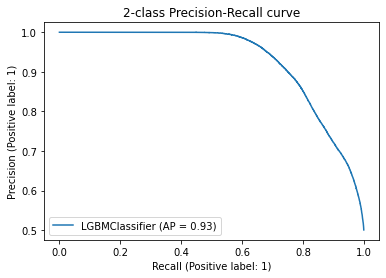

In [42]:
# Plotting the Precision-Recall curve
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), oof_preds.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

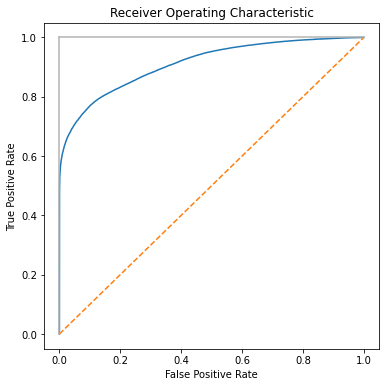

In [43]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), oof_preds.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

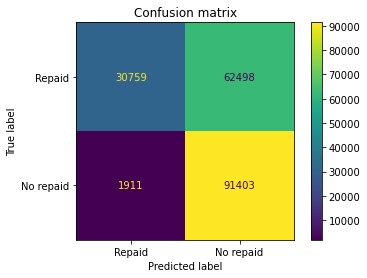

In [51]:
# Confusion matrix
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

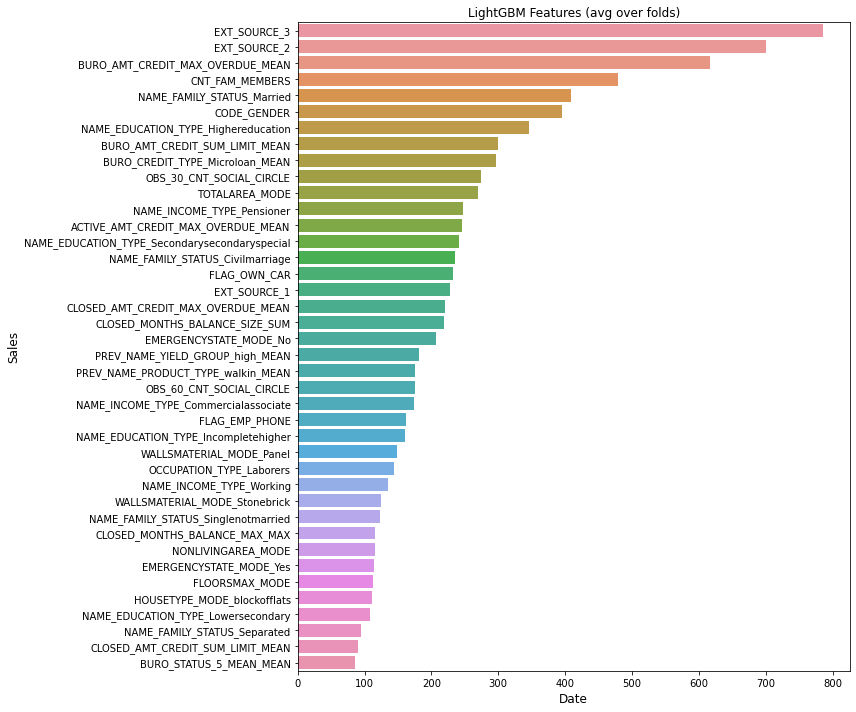

In [45]:
# Feature importance
feature_importance_df_ = pd.DataFrame({"importance":clf.feature_importances_, "feature":X.columns})

cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel('Date', fontsize=12);
plt.ylabel('Sales', fontsize=12);
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.5. Final re-training</h3>
</div>

<div class="alert alert-block alert-info">
    <p>First, we are going to free some memory</p>
</div>

In [46]:
del X_train_scaled, X_train, X_test_scaled, X_test
gc.collect()

16964

<div class="alert alert-block alert-info">
    <p>Scaling the data</p>
</div>

In [47]:
X_scaled = scaler.fit_transform(X)

In [48]:
clf.fit(X_scaled, y_target)

LGBMClassifier(colsample_bytree=0.8, is_unbalance=False,
               learning_rate=0.002996768103678267, max_depth=8,
               min_child_weight=43.56681976377634,
               min_split_gain=0.025360811467421862, n_estimators=8000,
               num_leaves=34, reg_alpha=0.047205508056568875,
               reg_lambda=0.07740351793970067, subsample=0.8)

In [49]:
# Saving the model based on the best parameters
joblib.dump(clf, "models/model_{version}.pkl".format(version=sklearn.__version__))

['models/model_1.0.2.pkl']